In [66]:
%run function_dbs.py
%run MLRegression_dbs.py
%matplotlib inline

fs, color = 10, 'k'
today = ''.join(str(datetime.today()).split(' ')[0].split('-'))

## Load spectral data and calibration information

In [3]:
# define path to where to find the absolute fluorescence intensity
ddata = pd.read_csv('460nm/20220831_trainingData_absoluteIntensity.csv', index_col=0).astype(float)
ddata.columns = [float(i) for i in ddata.columns[:-2]] + ['pH', 'O2 (%O2)']

# crop pH data to a range between pH 2-12 
df_ = ddata[ddata['pH'] < 12]
ddata = df_[df_['pH'] > 2]
ddata.index = np.arange(0, len(ddata.index))


# fluorescence spectra as features
df_features_ = ddata.loc[:, 470:900]

# adjust the precision: pH 1xdecimal, O2 1xdecimal
target_pH, target_O2 = [round(p,1) for p in ddata['pH']], [round(p,1) for p in ddata['O2 (%O2)']]

# --------------------------------
ddata.sample(5)

,470.0,472.8859,475.7718,478.6577,481.5436,484.4295,487.3154,490.2013,493.0872,495.9732,...,879.7987,882.6846,885.5705,888.4564,891.3423,894.2282,897.1141,900.0,pH,O2 (%O2)
5744,1.053061,1.071795,1.090590,1.109376,1.482563,2.189702,2.117212,2.051199,1.997114,1.908938,...,0.015153,0.015302,0.014168,0.012287,0.013324,0.013512,0.012501,0.013203,4.0,20.40
4494,0.625128,0.690441,0.755794,1.009764,1.033755,1.345501,1.469205,1.375110,1.175021,1.108304,...,0.020413,0.021399,0.020277,0.020783,0.020483,0.018253,0.016193,0.014920,11.0,6.76
371,1.232571,1.288634,1.331523,1.285892,1.509359,1.858991,1.985163,1.889815,1.787384,1.812393,...,0.046505,0.045443,0.044713,0.041727,0.038529,0.033887,0.030231,0.028289,8.0,0.00
1432,0.844568,0.921574,1.120234,1.081477,1.346305,1.721501,1.746720,1.580040,1.571556,1.498782,...,0.050187,0.051651,0.049233,0.047119,0.043788,0.036972,0.032220,0.030366,9.4,0.00
4533,0.325358,0.460454,0.595579,0.730700,0.953540,1.250886,1.389460,1.383377,1.210324,1.234150,...,0.031474,0.031182,0.030143,0.028416,0.025960,0.023964,0.022621,0.021509,11.0,6.76


Check the inbalance of the data set

- pH 7, 4, and 11 are overrepresented
- Quick note on how to deal with an imbalanced dataset: https://towardsdatascience.com/how-to-balance-a-dataset-in-python-36dff9d12704

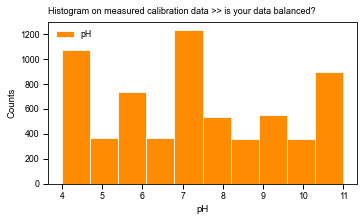

In [21]:
fig, ax = plt.subplots(figsize=(5,3))
fig.suptitle('Histogram on measured calibration data >> is your data balanced?', fontsize=9, color=color)

ax.hist(target_pH, color='darkorange', label='pH')
ax.legend(loc=2, frameon=False, fancybox=False, labelcolor=color)

ax.set_ylabel('Counts', color=color), ax.set_xlabel('pH', color=color)
ax.tick_params(axis='both', colors=color)
plt.tight_layout(pad=0.5)

# --------------------------------
# fig.savefig('20220926_dataset_Histogram_of_CalibrationPoints.svg', dpi=300, transparent=True)

# Prepare data set for pH

##### balance data set

In [9]:
df_features = pd.concat([df_features_, pd.DataFrame(target_O2, columns=['O2 (%O2)'])], axis=1)
df_features.index = pd.DataFrame(target_pH)[0].to_numpy()
print('raw data available: ', df_features.shape[0])

n_count_median = int(pd.DataFrame(target_pH).value_counts().median())
print('average sample size for each calibration point: ', n_count_median)

raw data available:  6476
average sample size for each calibration point:  360


In [31]:
### data adjustment

# get the pH points that are above the median
df_2smooth = pd.DataFrame(target_pH).value_counts()[pd.DataFrame(target_pH).value_counts() > n_count_median]
ls_smooth_ph = [x[0] for x in pd.DataFrame(df_2smooth).index]

# group prevailing data to larger chunks and smooth spectral information
df_ph_sm = data_smoothing(n_count_median=n_count_median, df_features=df_features, ls_smooth=ls_smooth_pH, analyte='pH')  

# --------------------------------------------------------------------
# re-combine reduced data set to the one that did not get smoothed -> balanced data set
ls_ph_remain = list(dict.fromkeys(target_pH)).copy()
[ls_ph_remain.remove(o) for o in ls_smooth_ph]

df_features.loc[:, 'pH'] = df_features.index
df_features_balanced = pd.concat([df_ph_sm, df_features.loc[ls_ph_remain]], axis=0)
df_features_balanced = df_features_balanced.sort_index()
df_features_ml = df_features_balanced.loc[:, 470:'O2 (%O2)']

# --------------------------------------------------------------------
# replace NaN values in dataFrame
df_features_ml = _replace_nan(df_features_ml, analyte='pH')

print('>> amount of NaNs in data set:', df_features_ml.isnull().sum().sum())
print('>> data points available upon balancing:', df_features_ml.shape[0])

/Applications/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Applications/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Applications/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


>> amount of NaNs in data set: 0
>> data points available upon balancing: 3720


upon balancing the data set is still not ideal, but it is much bettern than before

the data set is still bit unbalanced, but already much better than before


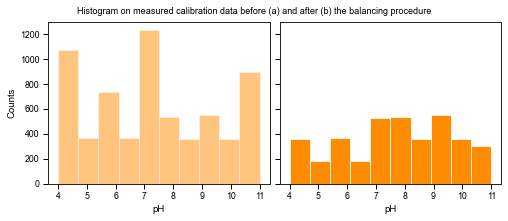

In [32]:
print('the data set is still bit unbalanced, but already much better than before')

# ---------------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(7,3), ncols=2, sharex=True, sharey=True)
fig.suptitle('Histogram on measured calibration data before (a) and after (b) the balancing procedure', fontsize=9, color=color)

ax[0].hist(target_pH, color='darkorange', label='pH', alpha=0.5)
ax[1].hist(df_features_balanced.index, color='darkorange')
ax[0].set_ylabel('Counts', color=color), ax[0].set_xlabel('pH', color=color), ax[1].set_xlabel('pH', color=color)
ax[0].tick_params(axis='both', colors=color), ax[1].tick_params(axis='both', colors=color)

plt.tight_layout(pad=0.5)

# ---------------------------------------------------------------------------------------
# save plot
# fig.savefig('20220926_balancedData_pH.svg', dpi=300, transparent=True)

## Save data

In [35]:
df_features_ml.to_csv(today + '_TrainingData-pH_balanced_absoluteInt.csv', sep='\t', decimal='.')

## Training data set inspection

In [39]:
# split the data into training and validation data
y_truth = df_features_ml.index              # n_samples (3720,) chosen analyte
X = df_features_ml                          # shape (n_features, n_samples) with (3720, 151)
X_train, X_valid, truth_train, truth_valid = train_test_split(X, y_truth, test_size=0.1, random_state=42)
X_train, X_valid = X_train.T, X_valid.T

print('in ML a rule of thumbs says that a suitable size for a data set is >1,000 samples')
print('size of data sets:')
print('> training data  ', X_train.shape, '\n> validation data', X_valid.shape)

in ML a rule of thumbs says that a suitable size for a data set is >1,000 samples
size of data sets:
> training data   (151, 3348) 
> validation data (151, 372)


In [40]:
# PCA as initial check whether a pattern is visible

# unsupervised dimension reduction for array-like data sets of shape (n_samples, n_features)
pca = PCA(n_components=min(X_train.shape), random_state=42)  
pca.fit(np.array(X_train).T)                                

# apply transform to dataset
X_train_dim_ = pca.transform(np.array(X_train).T)
X_valid_dim_ = pca.transform(np.array(X_valid).T)

print('[RESULTS]\n   ', pca)

[RESULTS]
    PCA(n_components=151, random_state=42)


The covariance shows which parameters are more important for separation (the brighter the more important). As it can be seen from the plot the wavelengths between 470-500nm (parameters 0-10) and 730-830 (parameters 91-126) are more important.

>> explained variance with PC1-11: 99.950%


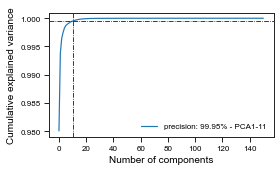

In [41]:
# which precision is sufficient?
precision = .9995

# find the PCAs that are needed to match the precision
cut = [k+1 for k, c in enumerate(np.cumsum(pca.explained_variance_ratio_)) if c < precision]

if len(cut) > 1:
    print('>> explained variance with PC1-{}: {:.3f}%'.format(cut[-1]+1, np.cumsum(pca.explained_variance_ratio_)[cut[-1]]*100))
    X_train_dim, X_valid_dim = X_train_dim_[:, :cut[-1]+1], X_valid_dim_[:, :cut[-1]+1]
else:
    X_train_dim, X_valid_dim = X_train_dim_, X_valid_dim_
    
# ------------------------------------------------------------------------------------------
# plot results
fig, ax = plt.subplots(figsize=(4,2.4))

ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.axhline(precision, lw=0.75, color=color, ls='-.')
if len(cut) > 1: 
    ax.axvline(cut[-1], color=color, lw=0.75, ls='-.')
else:
    cut = ['']
ax.legend(['precision: ' + str(precision*100) + '% - PCA1-{}'.format(cut[-1]+1) ], fontsize=8, frameon=False, labelcolor=color)

ax.set_xlabel('Number of components', fontsize=fs, color=color)
ax.set_ylabel('Cumulative explained variance', fontsize=fs, color=color)
ax.tick_params(labelsize=fs*0.8, labelcolor=color),
plt.tight_layout()
 
# ------------------------------------------------------------------------------------------
# save plot
# fig.savefig('CumVariance-pH_absoluteInt_{}.svg'.format(color), transparent=True, dpi=300)

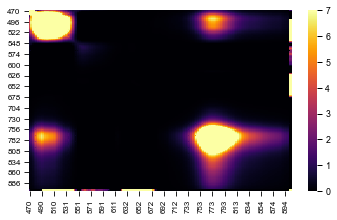

In [42]:
fig, ax = plt.subplots(figsize=(5,3))

sns.heatmap(pca.get_covariance() / np.nanmean(pca.get_covariance()), ax=ax, vmin=0, vmax=7, cmap='inferno')
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(colors=color)

ax.set_xticklabels([int(round(df_features_ml.columns[n*7],0)) for n in np.arange(22)])
ax.set_yticklabels([int(round(df_features_ml.columns[n*9],0)) for n in np.arange(17)])

ax.tick_params(labelsize=fs*0.8, labelcolor=color)
plt.tight_layout(pad=0.5)

# ------------------------------------------------------------------------------------------
# save plot
# fig.savefig('RelativeCovariance-pH_absoutInt_{}.svg'.format(color), transparent=True, dpi=300)

## Screening of different ML regression algorithms

the performance of the models is compared based on the mean absolute error (MAE) and the root-mean-square deviation/error (RMSE)

In [43]:
# 1) linear Regression 
reg_lin = make_pipeline(preprocessing.StandardScaler(), LinearRegression())

# 2) lasso Regression
reg_lasso = make_pipeline(preprocessing.StandardScaler(), Lasso())

# 3) rigide Regression
reg_rig = make_pipeline(preprocessing.StandardScaler(), Ridge())

# 4) logistic Regression
reg_log = make_pipeline(preprocessing.StandardScaler(), LogisticRegression())

# -------------------------------------------------------------
# 5) RandomForest Regression
reg_randF = make_pipeline(preprocessing.StandardScaler(), RandomForestRegressor())

# 6) SVM model
reg_SVR = make_pipeline( preprocessing.StandardScaler(), SVR())

# 7) K Nearest Neighbours
reg_kNN = make_pipeline(preprocessing.StandardScaler(), KNeighborsRegressor(n_neighbors=3))

# 8) Decision Tree
reg_DT = make_pipeline(preprocessing.StandardScaler(), DecisionTreeRegressor())

# 9) Xgboost
reg_XGB = make_pipeline(preprocessing.StandardScaler(), XGBRegressor())


# -------------------------------------------------------------
# combine all models
models_all = [reg_lin, reg_lasso, reg_rig, reg_log, reg_randF, reg_SVR, reg_kNN, reg_DT, reg_XGB]
methods = ['LIN', 'LAS', 'RIG', 'LOG', 'RF', 'SVR', 'kNN', 'DT', 'XGB']

In [54]:
# predict model performance for traning and validation data
derror = _perdict_model_performance(X_train=X_train_dim, X_valid=X_valid_dim, truth_train=truth_train, truth_valid=truth_valid, 
                                    methods=methods, models_all=models_all)
df_error = pd.concat(derror)

# -------------------------------------------------------------
print('Model performance without hyperparameter optimization\n')
pd.concat(derror)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model performance without hyperparameter optimization



mae          rmse           sdz
LinearRegression      training  4.597554e-01  6.031050e-01  1.148285e-01
                      test      4.944791e-01  6.603069e-01  1.379756e-01
Lasso                 training  1.300829e+00  1.561641e+00  2.784733e-01
                      test      1.379116e+00  1.658268e+00  3.197848e-01
Ridge                 training  4.597032e-01  6.031053e-01  1.148541e-01
                      test      4.944636e-01  6.603773e-01  1.380157e-01
LogisticRegression    training  3.492533e+01  7.255513e+01  1.429448e-01
                      test      3.736559e+01  7.987221e+01  1.753662e-01
RandomForestRegressor training  1.087903e-01  1.758328e-01  2.991611e-02
                      test      2.966962e-01  5.050076e-01  9.060014e-02
SVR                   training  2.920275e-01  4.274045e-01  8.195175e-02
                      test      3.841399e-01  5.642850e-01  1.171841e-01
KNeighborsRegressor   training  3.184289e-01  4.915950e-01  8.457894e-02
                      test      4.724910e-01  7.617165e-01  1.527449e-01
DecisionTreeRegressor training  7.083143e-17  4.289760e-16  5.696170e-17
                      test      3.250000e-01  6.664986e-01  1.124629e-01
XGBRegressor          training  7.117953e-02  1.003588e-01  1.424764e-02
                      test      3.236245e-01  4.746765e-01  8.217478e-02

In [110]:
print('Best performing ML algorithm(s)')

dT1 = pd.concat(derror).T.filter(like='training').T.sort_values('mae')['mae'][:3].index
dT2 = pd.concat(derror).T.filter(like='training').T.sort_values('rmse')['rmse'][:3].index
dv1 = pd.concat(derror).T.filter(like='test').T.sort_values('mae')['mae'][:3].index
dv2 = pd.concat(derror).T.filter(like='test').T.sort_values('rmse')['rmse'][:3].index

print('>> for training data: \t', sorted(list(dict.fromkeys([v[0] for v in dT1] + [v[0] for v in dT2]))))
print('>> for test data: \t', sorted(list(dict.fromkeys([v[0] for v in dv1] + [v[0] for v in dv2]))))

Best performing ML algorithm(s)
>> for training data: 	 ['DecisionTreeRegressor', 'RandomForestRegressor', 'XGBRegressor']
>> for test data: 	 ['DecisionTreeRegressor', 'RandomForestRegressor', 'SVR', 'XGBRegressor']
